In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil

# Directory where filtered images are stored
filtered_data_dir = 'filtered_data'

# Load the CSV file
data_dir = 'data'
csv_file = os.path.join(data_dir, 'train.csv')
df = pd.read_csv(csv_file)

# Filter the dataset to include only classes 0, 2, and 3
filtered_df = df[df['diagnosis'].isin([0, 2, 3])]

# Split the filtered data into train, validation, and test sets
train_df, temp_df = train_test_split(filtered_df, test_size=0.2, stratify=filtered_df['diagnosis'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['diagnosis'])

# Function to copy images to a new directory
def copy_images(df, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for label in [0, 2, 3]:
        label_dir = os.path.join(target_dir, str(label))
        os.makedirs(label_dir, exist_ok=True)
    
    for _, row in df.iterrows():
        img_name = row['id_code']  # Adjust this if the column name in your DataFrame is different
        label = row['diagnosis']
        src_path = os.path.join(filtered_data_dir, str(label), img_name + '.png')  # Assuming .png extension
        dst_path = os.path.join(target_dir, str(label), img_name + '.png')
        if os.path.exists(src_path):  # Check if the file exists
            shutil.copy(src_path, dst_path)
        else:
            print(f"Image {src_path} not found.")

# Create directories and copy images
train_data_dir = 'train_data'
val_data_dir = 'val_data'
test_data_dir = 'test_data'

copy_images(train_df, train_data_dir)
copy_images(val_df, val_data_dir)
copy_images(test_df, test_data_dir)


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data Augmentation and Preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize images to [0, 1] range
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # To create train/validation split if needed
)

# Load images and labels using ImageDataGenerator for train, validation, and test sets
train_generator = datagen.flow_from_directory(
    'train_data',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    'val_data',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'test_data',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 2870 images belonging to 3 classes.
Found 562 images belonging to 3 classes.
Found 572 images belonging to 3 classes.


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential()

# 1st Convolutional Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3))) 
# Input: (224, 224, 3), Output: (222, 222, 32)
# Explanation: 3x3 kernel reduces each dimension by 2, 32 filters increase depth.

# 1st Pooling Layer
model.add(layers.MaxPooling2D((2, 2))) 
# Input: (222, 222, 32), Output: (111, 111, 32)
# Explanation: Max pooling reduces each dimension by half, depth remains the same.

# 2nd Convolutional Layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Input: (111, 111, 32), Output: (109, 109, 64)
# Explanation: Kernel further reduces dimensions, and 64 filters increase depth.

# 2nd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# Input: (109, 109, 64), Output: (54, 54, 64)
# Explanation: Pooling reduces dimensions by half again.

# 3rd Convolutional Layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# Input: (54, 54, 64), Output: (52, 52, 128)
# Explanation: Kernel reduces spatial dimensions, 128 filters for richer features.

# 3rd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# Input: (52, 52, 128), Output: (26, 26, 128)
# Explanation: Pooling halves dimensions.

# 4th Convolutional Layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# Input: (26, 26, 128), Output: (24, 24, 128)

# 4th Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# Input: (24, 24, 128), Output: (12, 12, 128)

# Flatten the output to feed into Dense layers
model.add(layers.Flatten()) 
# Input: (12, 12, 128), Output: (18432)
# Explanation: Flatten converts 3D output into 1D vector.

# Dense Fully Connected Layer
model.add(layers.Dense(512, activation='relu'))
# Input: 18432, Output: 512
# Explanation: Fully connected layer reduces dimensionality to 512.

# Dropout Layer for regularization
model.add(layers.Dropout(0.5)) 
# Explanation: Dropout helps prevent overfitting by randomly turning off 50% of neurons.

# Output Layer
model.add(layers.Dense(3, activation='softmax'))
# Input: 512, Output: 3 (Number of classes)
# Explanation: Softmax for multi-class classification, outputs class probabilities.

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


/Users/mithindev/Desktop/COLLEGE/SEM-5/DL/CODE/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,680,067 (36.93 MB)

 Trainable params: 9,680,067 (36.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 49s 534ms/step - accuracy: 0.8725 - loss: 0.3775 - val_accuracy: 0.8879 - val_loss: 0.3211
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 0.0932 - val_accuracy: 0.8889 - val_loss: 0.5159
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 51s 558ms/step - accuracy: 0.8756 - loss: 0.3795 - val_accuracy: 0.8860 - val_loss: 0.3177
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8750 - loss: 0.4193 - val_accuracy: 0.9444 - val_loss: 0.3132
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 51s 553ms/step - accuracy: 0.8847 - loss: 0.3548 - val_accuracy: 0.8805 - val_loss: 0.3321
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step - accuracy: 0.9062 - loss: 0.2485 - val_accuracy: 0.8889 - val_loss: 0.2826
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 48s 517ms/step - accuracy: 0.8742 - loss: 0.3750 - val_accuracy: 0.8787 - val_loss: 0.3506
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8438 - loss: 0.4034 - val_accuracy: 0.83

2024-09-01 22:31:10.250630: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9675 - loss: 0.1413
Test Accuracy: 93.38%


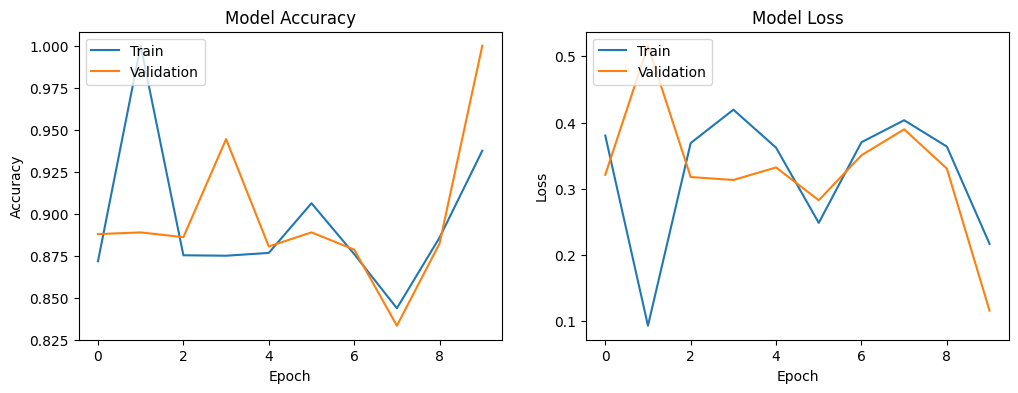

Test Loss: 0.2543
Test Accuracy: 93.38%


In [7]:
import matplotlib.pyplot as plt

# Define the number of epochs and steps per epoch
EPOCHS = 10

# Calculate the steps per epoch and validation steps
train_steps = train_generator.samples // BATCH_SIZE
val_steps = val_generator.samples // BATCH_SIZE

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_steps
)

# Evaluate the model on the test data
test_steps = test_generator.samples // BATCH_SIZE
test_loss, test_acc = model.evaluate(test_generator, steps=test_steps)

print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Print test accuracy and loss
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")
